In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import os
import matplotlib as mplc
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.cElementTree as ET
from urllib import urlopen
from lxml import html
import requests

http://www.nola.gov/nopd/crime-data/calls-for-service/

In [2]:
data = pd.read_csv('data/Calls_for_Service_2016.csv')
data.head()

NOPD_Item Type_               TypeText Priority     MapX    MapY  \
0  B1653516    21        COMPLAINT OTHER       1H  3670047  536220   
1  B1653616   107      SUSPICIOUS PERSON       2A  3680508  535443   
2  B1653716   21M          MISSING ADULT       1A  3691260  543498   
3  B1653816   62A  BURGLAR ALARM, SILENT       1A  3703312  557438   
4  B1653916    21        COMPLAINT OTHER       1H  3680983  531590   

               TimeCreate            TimeDispatch              TimeArrive  \
0  02/14/2016 12:00:10 PM                     NaN  02/14/2016 12:00:10 PM   
1  02/14/2016 12:03:26 PM  02/14/2016 12:04:07 PM  02/14/2016 12:10:16 PM   
2  02/14/2016 12:03:31 PM  02/14/2016 04:45:33 PM                     NaN   
3  02/14/2016 12:04:10 PM  02/14/2016 07:57:36 PM  02/14/2016 08:03:01 PM   
4  02/14/2016 12:07:49 PM  02/14/2016 12:07:49 PM  02/14/2016 12:08:35 PM   

               TimeClosed Disposition         DispositionText  \
0  02/14/2016 12:21:44 PM         NAT  Necessary Action Taken   
1  02/14/2016 12:12:17 PM         NAT  Necessary Action Taken   
2  02/14/2016 04:46:08 PM         VOI                    VOID   
3  02/14/2016 08:13:27 PM         NAT  Necessary Action Taken   
4  02/14/2016 12:35:01 PM         NAT  Necessary Action Taken   

                              BLOCK_ADDRESS      Zip  PoliceDistrict  \
0                         006XX S Pierce St  70119.0               1   
1  N Claiborne Ave (1F02) & Saint Philip St  70116.0               1   
2                     030XX Metropolitan St  70126.0               5   
3                        078XX S Coronet Ct  70126.0               7   
4                     002XX Blk Dauphine St  70112.0               8   

                      Location  
0  (29.96876417, -90.10407543)  
1  (29.96631442, -90.07106516)  
2  (29.98813222, -90.03682220)  
3  (30.02608100, -89.99824254)  
4  (29.95570616, -90.06969872)

In [3]:
# Parse location string to a tuple consisting of the latitude and longitude
def parse_location(loc_str):
    if loc_str[0] != '(' or loc_str[-1] != ')':
        return None
    sub = loc_str[1:-1].split(',')
    if len(sub) != 2:
        return None
    return float(sub[0]), float(sub[1])

In [4]:
lat, lon = zip(*data['Location'].apply(parse_location))
data['Latitude'] = lat
data['Longitude'] = lon
data = data[data['Longitude'] < -10]

In [5]:
data['TimeCreate'] = pd.to_datetime(data['TimeCreate'])
data['TimeDispatch'] = pd.to_datetime(data['TimeDispatch'])
data['TimeArrive'] = pd.to_datetime(data['TimeArrive'])
data['TimeClosed'] = pd.to_datetime(data['TimeClosed'])

## Most Reported

In [6]:
group = data.groupby('TypeText').size().reset_index()
most = group.sort_values(0, ascending=False).head()
most

TypeText      0
28         COMPLAINT OTHER  54173
24   BURGLAR ALARM, SILENT  25437
120       TRAFFIC INCIDENT  22936
38     DISTURBANCE (OTHER)  17193
16           AUTO ACCIDENT   9152

In [7]:
group.sort_values(0, ascending=True).head()

TypeText  0
0              ABANDONED BOAT  1
126  UNLAWFUL SALES TO MINORS  1
98      SIMPLE ARSON DOMESTIC  1
81                  PICKETING  1
80                PEEPING TOM  1

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216386 entries, 0 to 224282
Data columns (total 18 columns):
NOPD_Item          216386 non-null object
Type_              216386 non-null object
TypeText           216386 non-null object
Priority           216386 non-null object
MapX               216386 non-null int64
MapY               216386 non-null int64
TimeCreate         216386 non-null datetime64[ns]
TimeDispatch       157617 non-null datetime64[ns]
TimeArrive         168066 non-null datetime64[ns]
TimeClosed         216386 non-null datetime64[ns]
Disposition        216386 non-null object
DispositionText    216386 non-null object
BLOCK_ADDRESS      216386 non-null object
Zip                214371 non-null float64
PoliceDistrict     216386 non-null int64
Location           216386 non-null object
Latitude           216386 non-null float64
Longitude          216386 non-null float64
dtypes: datetime64[ns](4), float64(3), int64(3), object(8)
memory usage: 31.4+ MB


## Benchmark

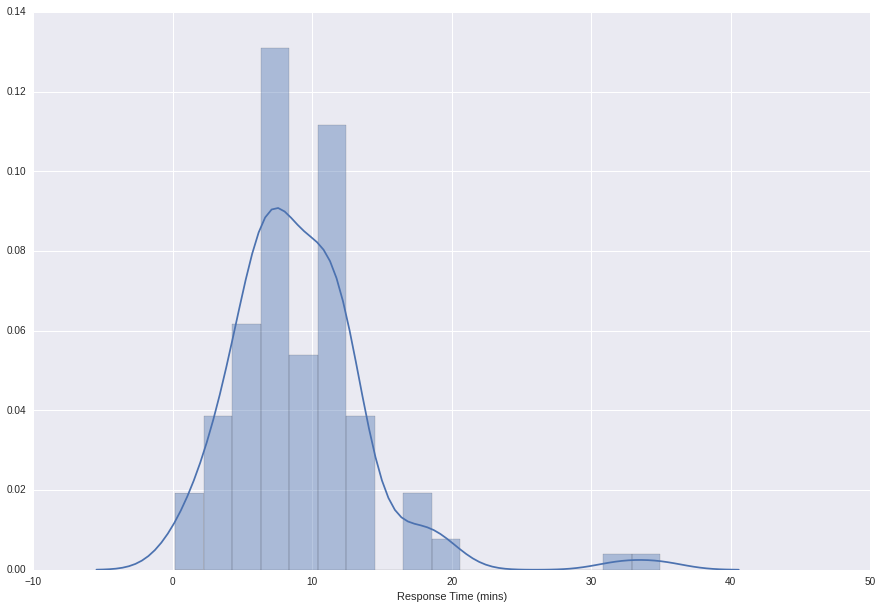

In [9]:
def avg_response_time(group):
    dispatch = group['TimeDispatch']
    arrival = group['TimeArrive']
    return float(np.mean(arrival - dispatch).seconds) / 60

sub_data = data[['TypeText', 'TimeDispatch', 'TimeArrive']].dropna()
sub_data = sub_data[sub_data['TimeDispatch'] < sub_data['TimeArrive']]
resp_time = sub_data.groupby('TypeText').apply(avg_response_time).reset_index()

plt.figure(figsize=(15,10))
sns.distplot(resp_time[0], axlabel='Response Time (mins)')

## Crime Density Map

In [10]:
most = list(most['TypeText'])

In [11]:
def generate_plot(data, crime):
    #mplc.rc("figure", figsize=(8, 8))
    crime_data = data[data['TypeText'] == crime]
    sns.jointplot(x="Latitude", y="Longitude", data=crime_data, kind="kde")
    plt.title(crime + " Density")

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


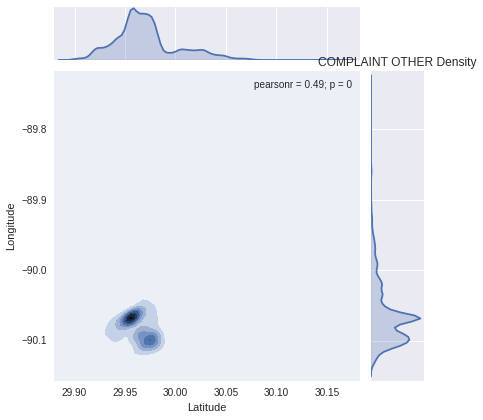

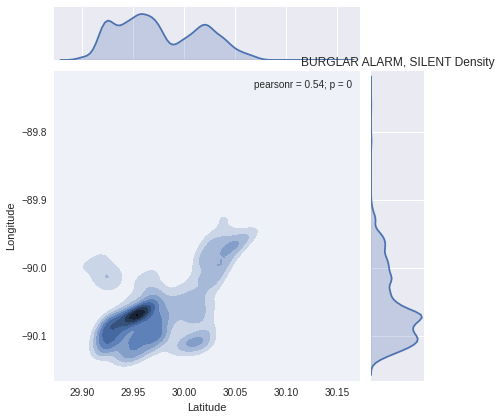

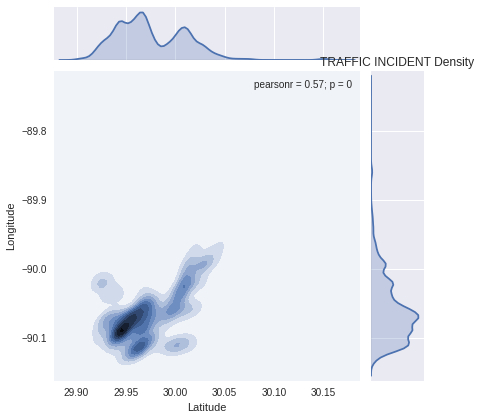

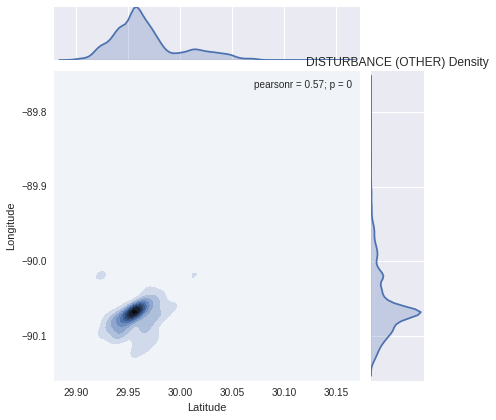

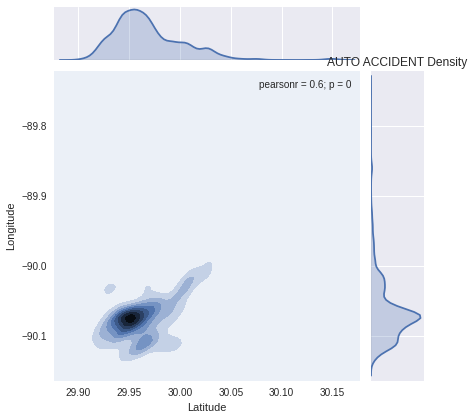

In [12]:
for i in most:
    generate_plot(data, i)

## Location

In [13]:
# Parse the data from the API
def parse_data(url):
    api_data = urlopen(url)
    data = []
    for event, elem in ET.iterparse(api_data, events=('start',)):
        if elem.tag == "region":
            d = {}
            for i in elem.iter():
                d[i.tag] = i.text
            if 'zindex' not in d.keys():
                if 'cityurl' in d.keys():
                    d['zindex'] = extract_index(d['cityurl'])
                elif 'url' in d.keys():
                    d['zindex'] = extract_index(d['url'])
            data.append(d)
    return pd.DataFrame(data)

# Extract the value from the provided url if the data is missing
def extract_index(url):
    page = requests.get(url)
    tree = html.fromstring(page.content)
    values = tree.xpath('//*[@class="region-info-item"]//h2//text()')
    if len(values) < 1:
        return None
    value = values[0][1:]
    value = ''.join(value.split(','))
    if value.isdigit():
        return float(value)
    return None 

In [14]:
api_key = os.environ['ZILLOW_API_KEY']

housing_url = "http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=" + api_key + "&state=LA&city=new%20orleans&childtype=neighborhood"
df = parse_data(housing_url)

In [15]:
df.head()

id   latitude   longitude          name region  \
0   19594  30.021467  -89.882696           NaN   None   
1  152379  30.051035  -89.986844  Little Woods   None   
2  269720  29.925044  -89.999917    Old Aurora   None   
3  272821  29.934169  -90.122551       Audubon   None   
4  269717  29.970796  -90.099308      Mid-City   None   

                                                 url    zindex  
0                                                NaN       NaN  
1  http://www.zillow.com/local-info/LA-New-Orlean...  136800.0  
2  http://www.zillow.com/local-info/LA-New-Orlean...  162800.0  
3  http://www.zillow.com/local-info/LA-New-Orlean...  859000.0  
4  http://www.zillow.com/local-info/LA-New-Orlean...  285600.0

In [16]:
sub_df = df[['latitude', 'longitude', 'zindex']].dropna()
sub_df['latitude'] = pd.to_numeric(sub_df['latitude'])
sub_df['longitude'] = pd.to_numeric(sub_df['longitude'])
sub_df['zindex'] = pd.to_numeric(sub_df['zindex'])

In [17]:
lat = np.array(sub_df['latitude'])
lon = np.array(sub_df['longitude'])
val = np.array(sub_df['zindex'])
val = val * 30/ min(val)

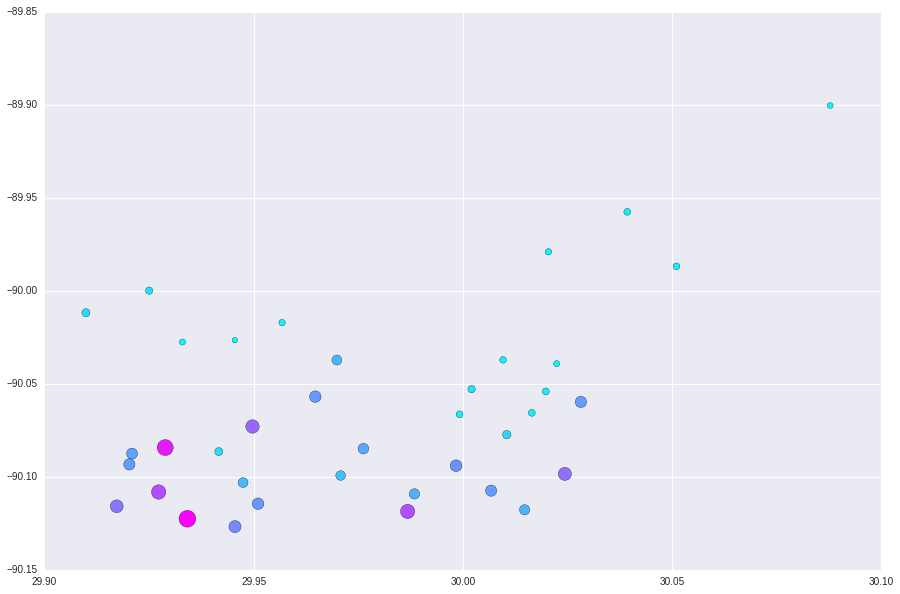

In [18]:
plt.figure(figsize=(15,10))

plt.scatter(x=lat, y=lon, c = val, s = val, cmap='cool')